
# ALS signature using S-PrediXcan
***

In [20]:
from datetime import date
today = date.today()
date= today.strftime("%B %d, %Y")
import getpass
import os
cwd = os.getcwd()

In [19]:
print("Date: ", date)
print("")
print("Analysed by: ", getpass.getuser())
print("")
print("Current working directory: {0}".format(cwd))
print("")

Date:  August 11, 2022

Analysed by:  saezs

Current working directory: /gpfs/gsfs11/users/ALS_50k/SaraSaez_ALS/2022_01_06.ALS.DrugsRepositioning




# Workflow

***


<b>  (1) Download ALS GWAS summary Stats </b>  (Van Rheenen et al., 2021) __[Project Mine](https://surfdrive.surf.nl/files/index.php/s/E5RetKw10hC3jXy)__



     
       
<br> <b>   (2) S-PrediXcan Workflow </b>

            (2.1) ALS GWAS harmonization and formating
   

            (2.2) Imputation
   
         
            (2.3) Imputation post-processing
   
         
            (2.4) S-PrediXcan 
     
   
<br> <b>   (3) Built ALS signatures</b> with the up/dn- regulated gene 

<br> <b>   (4) Visualization</b> of the results


<br> 

<br> 
    
# Requiered files
***

   (1) ALS GWAS Summara Stas

       - /data/ADRD/2021_07_01.Methylation/COMBINED/meffil/*.idat

   (2) Downloaded S-PrediXcan files/ scripts</br>

       - original files: /data/ADRD/ipsc_qtl/analyses/genotypes/imputed/adrd_ipsc.imputed.bfile 
       


<div class="alert alert-block alert-info">

<b>Note:</b> Activate conda environment <b>projectsara3</b> for imputation from terminal! 
 
[Imputation](###-Imputation)

<br>


# Analysis

***

## Download the latest ALS GWAS (Van Rheenen et al., 2021)
The download is not working from EBI. Only works from Project Mine, but the direct link is not working so I downloaded to my laptop and transfered it to biowulf.

In [38]:
!pwd
!wget https://surfdrive.surf.nl/files/index.php/s/E5RetKw10hC3jXy/download?path=%2F&files=ALS_GWAS_RVB_SMR_sumstats.tar.g
# Descompress the file
! tar -xvf ALS_GWAS_RVB_SMR_sumstats.tar

/data/ALS_50k/SaraSaez_ALS/2022_01_06.ALS.DrugsRepositioning


In [27]:
%%bash
cat GWAS/ALS_sumstats_EUR_only.README
md5sum GWAS/ALS_sumstats_EUR_only.txt.gz
head GWAS/ALS_sumstats_EUR_only.txt
zcat GWAS/ALS_sumstats_EUR_only.txt.gz > GWAS/ALS_sumstats_EUR_only.txt
md5sum GWAS/ALS_sumstats_EUR_only.txt

# the checksum is fine!!! Van Rheenen just confirmed

van Rheenen W, van der Spek RAA, Bakker MK, et al (2021) Common and rare variant association analyses in Amyotrophic Lateral Sclerosis identify 15 risk loci with distinct genetic architectures and neuron-specific biology. medRxiv. doi: https://doi.org/10.1101/2021.03.12.21253159

These summary statistics describe the *European ancestries* meta-analysis GWAS.

filename: ALS_sumstats_EUR_only.txt.gz
md5sum: 4a515bfb365bbeda5599c846c00c38f7 

Field description:
rsid: The rsid of the variant
chromosome: The chromosome that the variant is located on (build hg19)
base_pair_location: The base pair location of the variant (build hg19)
effect_allele: The effect allele of the variant
other_allele: The non-effect allele
effect_allele_frequency: Frequency of the effect allele in total GWAS (cases and controls)
beta: The beta of the variant/trait association
standard_error: The standard error of the beta
p_value: The p-value of the variant/trait association
N_effective: effective sample size for va

## S-PrediXcan
### ALS GWAS harmonization and formatting
Using MetaXcan's built-in harmonization.

In [30]:
%%bash
cd /data/saezs/
. conda/etc/profile.d/conda.sh
conda activate projectsara3

python /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/MetaXcan-master/software/M03_betas.py \
--snp_map_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/coordinate_map/map_snp150_hg19.txt.gz \
--gwas_file /data/ALS_50k/SaraSaez_ALS/2022_01_06.ALS.DrugsRepositioning/GWAS/ALS_sumstats_EUR_only.txt.gz \
--snp_column rsid \
--non_effect_allele_column other_allele \
--effect_allele_column effect_allele \
--beta_column beta \
--pvalue_column p_value  \
--keep_non_rsid \
--throw \
--output /data/ALS_50k/SaraSaez_ALS/2022_01_06.ALS.DrugsRepositioning/ALS_ADDITIVE_quick.ALS_VanRheenen2021.gz


INFO - Processing GWAS command line parameters
INFO - Building beta for /data/ALS_50k/SaraSaez_ALS/2022_01_06.ALS.DrugsRepositioning/GWAS/ALS_sumstats_EUR_only.txt.gz and no database
INFO - Reading input gwas: /data/ALS_50k/SaraSaez_ALS/2022_01_06.ALS.DrugsRepositioning/GWAS/ALS_sumstats_EUR_only.txt.gz
INFO - Processing input gwas
INFO - Loading mapping
INFO - Mapping variants
INFO - Saving /data/ALS_50k/SaraSaez_ALS/2022_01_06.ALS.DrugsRepositioning/ALS_ADDITIVE_quick.ALS_VanRheenen2021.gz
INFO - Successfully ran GWAS input processing in 295.79866820108145 seconds


<div class="alert alert-block alert-warning">
<b> Alert! </b> harmonized GWAS has variants in hg38 version 
</div>


The quick harmonization I performed did not provide the formatted file needed for imputation, so I added this extra step.

In [36]:
%%bash
cd /data/ALS_50k/SaraSaez_ALS/2022_01_06.ALS.DrugsRepositioning/
zcat ALS_ADDITIVE_quick.ALS_VanRheenen2021.gz > ALS_ADDITIVE_quick.ALS_VanRheenen2021.txt


module load R/4.0.3
R --vanilla --no-save
library(data.table)
library(tidyverse)
library(dplyr)
data = fread("ALS_ADDITIVE_quick.ALS_VanRheenen2021.gz", header = T)
head(data)
data$sample_size = 138086
data$n_cases = 27205
data$effect_size = data$beta 
data$panel_variant_id = data$snp 
data$variant_id = data$gwas_snp 
data = data %>% separate(snp, c("chromosome", "position"), extra = "drop", fill = "right")
head(data)

#I need se and EAF so i need to open the original GWAS and take the info from there

data2 = fread("GWAS/ALS_sumstats_EUR_only.txt.gz", header = T)
head(data2)

data2$variant_id = data2$rsid
data2$frequency = data2$effect_allele_frequency
data2<- select(data2, variant_id, standard_error,frequency)
merged = merge(data, data2, by = "variant_id")


dataprint = select (merged, variant_id, panel_variant_id, chromosome, position, effect_allele, non_effect_allele, frequency, pvalue, zscore, effect_size, standard_error, sample_size, n_cases)
write.table(dataprint, "ALS.VanRheenen2021_quick.Formatted.harmonized.txt", quote = F, row.names = F, sep = " ")


R version 4.0.3 (2020-10-10) -- "Bunny-Wunnies Freak Out"
Copyright (C) 2020 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> library(data.table)
> library(tidyverse)
> library(dplyr)
> data = fread("ALS_ADDITIVE_quick.ALS_VanRheenen2021.gz", header = T)
> head(data)
      gwas_snp gwas_effect_allele gwas_non_effect_allele                 snp
1:  rs11240777                  A                      G chr1_863579_G_A_b38
2: 

[+] Loading gcc  9.2.0  ... 
[+] Loading GSL 2.6 for GCC 9.2.0 ...
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading openmpi 3.1.4  for GCC 9.2.0 
[+] Loading ImageMagick  7.0.8  on cn1085 
[+] Loading HDF5  1.10.4 
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading NetCDF 4.7.4_gcc9.2.0 
[+] Loading pandoc  2.16.2  on cn1085 
[+] Loading pcre2 10.21  ... 
[+] Loading R 4.0.3 
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpo

In [37]:
%%bash
module load samtools
bgzip ALS.VanRheenen2021_quick.Formatted.harmonized.txt

scp ALS.VanRheenen2021_quick.Formatted.harmonized.txt.gz /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/harmonized_gwas/


[+] Loading samtools 1.13  ... 


### Imputation
Run imputation from the terminal to active my conda environment

`cd /data/saezs/`

`. conda/etc/profile.d/conda.sh`

`conda activate projectsara3`

`swarm -f VR.ALS_20220203IMPUTATION_swarms -g 15 -t 24 --time 240:00:00 --logdir`

<div class="alert alert-block alert-success">
<b><i class="fa fa-lightbulb-o "></i>  Successful swarm job!
    
   jobID:29797127</b>
    
/data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Swarms_oe

</div>


In [ ]:
%%bash
#check the output imputed files

cd  /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/summary_imputation_1000G/
ls VR.ALS.quick.harmo.YESfreq_chr* | wc -l
wc -l VR.ALS.quick.harmo.YESfreq_chr* 
scp VR.ALS.quick.harmo.YESfreq_chr* /data/ALS_50k/SaraSaez_ALS/2022_01_06.ALS.DrugsRepositioning/

In [2]:
%%bash
cd /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/harmonized_gwas
module load R/4.0.3
R --vanilla --no-save
library(data.table)
library(tidyverse)
library(dplyr)
data = fread("ALS.VanRheenen2021_quick.Formatted.harmonized.txt.gz", header = T)
write.table(data, "ALS.VanRheenen2021_quick.Formatted.harmonized.tabul.txt", quote = F, row.names = F, sep = "\t")


R version 4.0.3 (2020-10-10) -- "Bunny-Wunnies Freak Out"
Copyright (C) 2020 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> library(data.table)
> library(tidyverse)
> library(dplyr)
> data = fread("ALS.VanRheenen2021_quick.Formatted.harmonized.txt.gz", header = T)
> write.table(data, "ALS.VanRheenen2021_quick.Formatted.harmonized.tabul.txt", quote = F, row.names = F, sep = "\t")
> 


[+] Loading gcc  9.2.0  ... 
[+] Loading GSL 2.6 for GCC 9.2.0 ...
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading openmpi 3.1.4  for GCC 9.2.0 
[+] Loading ImageMagick  7.0.8  on cn0851 
[+] Loading HDF5  1.10.4 
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading NetCDF 4.7.4_gcc9.2.0 
[+] Loading pandoc  2.16.2  on cn0851 
[+] Loading pcre2 10.21  ... 
[+] Loading R 4.0.3 
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpo

In [5]:
%%bash
cd /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/harmonized_gwas
module load samtools
bgzip ALS.VanRheenen2021_quick.Formatted.harmonized.tabul.txt



[+] Loading samtools 1.13  ... 


### Imputation post-processing

In [7]:
%%bash
cd /data/saezs/
scp ALS.chr1-22_swarms /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Swarms
. conda/etc/profile.d/conda.sh
conda activate projectsara3
python /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/summary-gwas-imputation-master/src/gwas_summary_imputation_postprocess.py \
-gwas_file  /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/harmonized_gwas/ALS.VanRheenen2021_quick.Formatted.harmonized.tabul.txt.gz \
-folder /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/summary_imputation_1000G \
-pattern VR.ALS.quick.harmo* \
-parsimony 7 \
-output /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/processed_summary_imputation/imputed_VR.ALS.quick.harmo.YESfreq.txt.gz

INFO - Output exists. Nope.


In [8]:
%%bash
cd /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/
echo "How many available tissues do we have?" 
ls *.db | wc -l
ls
echo "How many available BRAIN tissues do we have?" 
ls *Brain*.db | wc -l
ls *Brain*.db

How many available tissues do we have?
49
mashr_Adipose_Subcutaneous.db
mashr_Adipose_Subcutaneous.txt.gz
mashr_Adipose_Visceral_Omentum.db
mashr_Adipose_Visceral_Omentum.txt.gz
mashr_Adrenal_Gland.db
mashr_Adrenal_Gland.txt.gz
mashr_Artery_Aorta.db
mashr_Artery_Aorta.txt.gz
mashr_Artery_Coronary.db
mashr_Artery_Coronary.txt.gz
mashr_Artery_Tibial.db
mashr_Artery_Tibial.txt.gz
mashr_Brain_Amygdala.db
mashr_Brain_Amygdala.txt.gz
mashr_Brain_Anterior_cingulate_cortex_BA24.db
mashr_Brain_Anterior_cingulate_cortex_BA24.txt.gz
mashr_Brain_Caudate_basal_ganglia.db
mashr_Brain_Caudate_basal_ganglia.txt.gz
mashr_Brain_Cerebellar_Hemisphere.db
mashr_Brain_Cerebellar_Hemisphere.txt.gz
mashr_Brain_Cerebellum.db
mashr_Brain_Cerebellum.txt.gz
mashr_Brain_Cortex.db
mashr_Brain_Cortex.txt.gz
mashr_Brain_Frontal_Cortex_BA9.db
mashr_Brain_Frontal_Cortex_BA9.txt.gz
mashr_Brain_Hippocampus.db
mashr_Brain_Hippocampus.txt.gz
mashr_Brain_Hypothalamus.db
mashr_Brain_Hypothalamus.txt.gz
mashr_Brain_Nucleus_ac

### S-PrediXcan

In [11]:
%%bash

cd /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS

echo "python /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/MetaXcan-master/software/SPrediXcan.py --gwas_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/processed_summary_imputation/imputed_VR.ALS.quick.harmo.YESfreq.txt.gz --snp_column panel_variant_id --effect_allele_column effect_allele --non_effect_allele_column non_effect_allele --zscore_column zscore --model_db_path /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Whole_Blood.db --covariance /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Whole_Blood.txt.gz --keep_non_rsid --additional_output --model_db_snp_key varID --throw --output_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Whole_Blood.csv
python /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/MetaXcan-master/software/SPrediXcan.py --gwas_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/processed_summary_imputation/imputed_VR.ALS.quick.harmo.YESfreq.txt.gz --snp_column panel_variant_id --effect_allele_column effect_allele --non_effect_allele_column non_effect_allele --zscore_column zscore --model_db_path /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Amygdala.db --covariance /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Amygdala.txt.gz --keep_non_rsid --additional_output --model_db_snp_key varID --throw --output_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Amygdala.csv
python /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/MetaXcan-master/software/SPrediXcan.py --gwas_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/processed_summary_imputation/imputed_VR.ALS.quick.harmo.YESfreq.txt.gz --snp_column panel_variant_id --effect_allele_column effect_allele --non_effect_allele_column non_effect_allele --zscore_column zscore --model_db_path /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Anterior_cingulate_cortex_BA24.db --covariance /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Anterior_cingulate_cortex_BA24.txt.gz --keep_non_rsid --additional_output --model_db_snp_key varID --throw --output_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Anterior_cingulate_cortex_BA24.csv
python /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/MetaXcan-master/software/SPrediXcan.py --gwas_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/processed_summary_imputation/imputed_VR.ALS.quick.harmo.YESfreq.txt.gz --snp_column panel_variant_id --effect_allele_column effect_allele --non_effect_allele_column non_effect_allele --zscore_column zscore --model_db_path /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Caudate_basal_ganglia.db --covariance /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Caudate_basal_ganglia.txt.gz --keep_non_rsid --additional_output --model_db_snp_key varID --throw --output_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Caudate_basal_ganglia.csv
python /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/MetaXcan-master/software/SPrediXcan.py --gwas_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/processed_summary_imputation/imputed_VR.ALS.quick.harmo.YESfreq.txt.gz --snp_column panel_variant_id --effect_allele_column effect_allele --non_effect_allele_column non_effect_allele --zscore_column zscore --model_db_path /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Cerebellar_Hemisphere.db --covariance /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Cerebellar_Hemisphere.txt.gz --keep_non_rsid --additional_output --model_db_snp_key varID --throw --output_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Cerebellar_Hemisphere.csv
python /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/MetaXcan-master/software/SPrediXcan.py --gwas_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/processed_summary_imputation/imputed_VR.ALS.quick.harmo.YESfreq.txt.gz --snp_column panel_variant_id --effect_allele_column effect_allele --non_effect_allele_column non_effect_allele --zscore_column zscore --model_db_path /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Cerebellum.db --covariance /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Cerebellum.txt.gz --keep_non_rsid --additional_output --model_db_snp_key varID --throw --output_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Cerebellum.csv
python /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/MetaXcan-master/software/SPrediXcan.py --gwas_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/processed_summary_imputation/imputed_VR.ALS.quick.harmo.YESfreq.txt.gz --snp_column panel_variant_id --effect_allele_column effect_allele --non_effect_allele_column non_effect_allele --zscore_column zscore --model_db_path /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Cortex.db --covariance /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Cortex.txt.gz --keep_non_rsid --additional_output --model_db_snp_key varID --throw --output_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Cortex.csv
python /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/MetaXcan-master/software/SPrediXcan.py --gwas_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/processed_summary_imputation/imputed_VR.ALS.quick.harmo.YESfreq.txt.gz --snp_column panel_variant_id --effect_allele_column effect_allele --non_effect_allele_column non_effect_allele --zscore_column zscore --model_db_path /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Frontal_Cortex_BA9.db --covariance /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Frontal_Cortex_BA9.txt.gz --keep_non_rsid --additional_output --model_db_snp_key varID --throw --output_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Frontal_Cortex_BA9.csv
python /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/MetaXcan-master/software/SPrediXcan.py --gwas_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/processed_summary_imputation/imputed_VR.ALS.quick.harmo.YESfreq.txt.gz --snp_column panel_variant_id --effect_allele_column effect_allele --non_effect_allele_column non_effect_allele --zscore_column zscore --model_db_path /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Hippocampus.db --covariance /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Hippocampus.txt.gz --keep_non_rsid --additional_output --model_db_snp_key varID --throw --output_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.harmo.YESfreq_PM_Brain_Hippocampus.csv
python /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/MetaXcan-master/software/SPrediXcan.py --gwas_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/processed_summary_imputation/imputed_VR.ALS.quick.harmo.YESfreq.txt.gz --snp_column panel_variant_id --effect_allele_column effect_allele --non_effect_allele_column non_effect_allele --zscore_column zscore --model_db_path /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Hypothalamus.db --covariance /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Hypothalamus.txt.gz --keep_non_rsid --additional_output --model_db_snp_key varID --throw --output_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Hypothalamus.csv
python /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/MetaXcan-master/software/SPrediXcan.py --gwas_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/processed_summary_imputation/imputed_VR.ALS.quick.harmo.YESfreq.txt.gz --snp_column panel_variant_id --effect_allele_column effect_allele --non_effect_allele_column non_effect_allele --zscore_column zscore --model_db_path /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Nucleus_accumbens_basal_ganglia.db --covariance /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Nucleus_accumbens_basal_ganglia.txt.gz --keep_non_rsid --additional_output --model_db_snp_key varID --throw --output_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Nucleus_accumbens_basal_ganglia.csv
python /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/MetaXcan-master/software/SPrediXcan.py --gwas_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/processed_summary_imputation/imputed_VR.ALS.quick.harmo.YESfreq.txt.gz --snp_column panel_variant_id --effect_allele_column effect_allele --non_effect_allele_column non_effect_allele --zscore_column zscore --model_db_path /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Putamen_basal_ganglia.db --covariance /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Putamen_basal_ganglia.txt.gz --keep_non_rsid --additional_output --model_db_snp_key varID --throw --output_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Putamen_basal_ganglia.csv
python /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/MetaXcan-master/software/SPrediXcan.py --gwas_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/processed_summary_imputation/imputed_VR.ALS.quick.harmo.YESfreq.txt.gz --snp_column panel_variant_id --effect_allele_column effect_allele --non_effect_allele_column non_effect_allele --zscore_column zscore --model_db_path /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Spinal_cord_cervical_c-1.db --covariance /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Spinal_cord_cervical_c-1.txt.gz --keep_non_rsid --additional_output --model_db_snp_key varID --throw --output_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Spinal_cord_cervical_c-1.csv
python /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/MetaXcan-master/software/SPrediXcan.py --gwas_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/processed_summary_imputation/imputed_VR.ALS.quick.harmo.YESfreq.txt.gz --snp_column panel_variant_id --effect_allele_column effect_allele --non_effect_allele_column non_effect_allele --zscore_column zscore --model_db_path /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Substantia_nigra.db --covariance /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Brain_Substantia_nigra.txt.gz --keep_non_rsid --additional_output --model_db_snp_key varID --throw --output_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Substantia_nigra.csv
python /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/MetaXcan-master/software/SPrediXcan.py --gwas_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/processed_summary_imputation/imputed_VR.ALS.quick.harmo.YESfreq.txt.gz --snp_column panel_variant_id --effect_allele_column effect_allele --non_effect_allele_column non_effect_allele --zscore_column zscore --model_db_path /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Muscle_Skeletal.db --covariance /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/mashr_Muscle_Skeletal.txt.gz --keep_non_rsid --additional_output --model_db_snp_key varID --throw --output_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Muscle_Skeletal.csv" > Spredixcan.VR.ALS.15tissues_swarms

swarm -f Spredixcan.VR.ALS.15tissues_swarms -g 150 -t 24 --time 240:00:00 --logdir /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Swarms_oe

29847738


mkdir: cannot create directory ‘VR2021.ALS’: File exists


### Run MetaXcan (Additional)
These has to be done from the terminal

In [ ]:
cd /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/smetaxcan/
mkdir VR2021.ALS
cd /data/saezs/
. conda/etc/profile.d/conda.sh
conda activate projectsara3


python /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/MetaXcan-master/software/SMulTiXcan.py \
--models_folder /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/tometa \
--models_name_pattern "mashr_(.*).db" \
--snp_covariance /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/gtex_v8_expression_mashr_snp_smultixcan_covariance.txt.gz \
--metaxcan_folder /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS \
--metaxcan_filter "VR.ALS.quick.harmo.YESfreq_PM_Brain_(.*).csv" \
--metaxcan_file_name_parse_pattern "(.*)_PM_(.*).csv" \
--gwas_file /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/processed_summary_imputation/imputed_VR.ALS.quick.harmo.YESfreq.txt.gz \
--snp_column panel_variant_id \
--effect_allele_column effect_allele \
--non_effect_allele_column non_effect_allele \
--zscore_column zscore \
--keep_non_rsid \
--model_db_snp_key varID \
--cutoff_condition_number 30 \
--verbosity 7 \
--throw \
--output /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/smetaxcan/VR2021.ALS/VR.ALS.quick.harmo.smultixcan.txt


In [ ]:
# log file
INFO - Creating context
INFO - Creating MetaXcan results manager
Level 9 - Loading metaxcan /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Amygdala.csv
Level 9 - Loading metaxcan /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Anterior_cingulate_cortex_BA24.csv
Level 9 - Loading metaxcan /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Caudate_basal_ganglia.csv
Level 9 - Loading metaxcan /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Cerebellar_Hemisphere.csv
Level 9 - Loading metaxcan /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Cerebellum.csv
Level 9 - Loading metaxcan /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Cortex.csv
Level 9 - Loading metaxcan /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Frontal_Cortex_BA9.csv
Level 9 - Loading metaxcan /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Hypothalamus.csv
Level 9 - Loading metaxcan /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Nucleus_accumbens_basal_ganglia.csv
Level 9 - Loading metaxcan /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Putamen_basal_ganglia.csv
Level 9 - Loading metaxcan /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Spinal_cord_cervical_c-1.csv
Level 9 - Loading metaxcan /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/VR.ALS.quick.harmo.YESfreq_PM_Brain_Substantia_nigra.csv
Level 9 - Building data
Level 9 - Processing Brain_Amygdala
Level 9 - Processing Brain_Anterior_cingulate_cortex_BA24
Level 9 - Processing Brain_Caudate_basal_ganglia
Level 9 - Processing Brain_Cerebellar_Hemisphere
Level 9 - Processing Brain_Cerebellum
Level 9 - Processing Brain_Cortex
Level 9 - Processing Brain_Frontal_Cortex_BA9
Level 9 - Processing Brain_Hypothalamus
Level 9 - Processing Brain_Nucleus_accumbens_basal_ganglia
Level 9 - Processing Brain_Putamen_basal_ganglia
Level 9 - Processing Brain_Spinal_cord_cervical_c-1
Level 9 - Processing Brain_Substantia_nigra
INFO - Loading genes
INFO - Context for snp covariance
INFO - Assessing GWAS-Models SNP intersection
INFO - Processing GWAS command line parameters
INFO - Reading input gwas: /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/processed_summary_imputation/imputed_VR.ALS.quick.harmo.YESfreq.txt.gz
INFO - Processing input gwas
Level 9 - Using declared zscore
Level 9 - loading /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/tometa/mashr_Brain_Amygdala.db
Level 9 - loading /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/tometa/mashr_Brain_Anterior_cingulate_cortex_BA24.db
Level 9 - loading /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/tometa/mashr_Brain_Caudate_basal_ganglia.db
Level 9 - loading /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/tometa/mashr_Brain_Cerebellar_Hemisphere.db
Level 9 - loading /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/tometa/mashr_Brain_Cerebellum.db
Level 9 - loading /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/tometa/mashr_Brain_Cortex.db
Level 9 - loading /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/tometa/mashr_Brain_Frontal_Cortex_BA9.db
Level 9 - loading /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/tometa/mashr_Brain_Hippocampus.db
Level 9 - loading /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/tometa/mashr_Brain_Hypothalamus.db
Level 9 - loading /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/tometa/mashr_Brain_Nucleus_accumbens_basal_ganglia.db
Level 9 - loading /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/tometa/mashr_Brain_Putamen_basal_ganglia.db
Level 9 - loading /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/tometa/mashr_Brain_Spinal_cord_cervical_c-1.db
Level 9 - loading /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/tometa/mashr_Brain_Substantia_nigra.db
Level 9 - loading /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/tometa/mashr_Muscle_Skeletal.db
Level 9 - loading /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Scr/data/models/eqtl/mashr/tometa/mashr_Whole_Blood.db
INFO - Loading Model Manager
Level 9 - preloading models
Level 9 - processing Brain_Amygdala
Level 9 - processing Brain_Anterior_cingulate_cortex_BA24
Level 9 - processing Brain_Caudate_basal_ganglia
Level 9 - processing Brain_Cerebellar_Hemisphere
Level 9 - processing Brain_Cerebellum
Level 9 - processing Brain_Cortex
Level 9 - processing Brain_Frontal_Cortex_BA9
Level 9 - processing Brain_Hippocampus
Level 9 - processing Brain_Hypothalamus
Level 9 - processing Brain_Nucleus_accumbens_basal_ganglia
Level 9 - processing Brain_Putamen_basal_ganglia
Level 9 - processing Brain_Spinal_cord_cervical_c-1
Level 9 - processing Brain_Substantia_nigra
Level 9 - processing Muscle_Skeletal
Level 9 - processing Whole_Blood
Level 9 - preparing models (dictionary layout)
INFO - Preparing SNP covariance
INFO - Processing
Level 7 - Gene 1/19359: ENSG00000169583.12Level 7 - Gene 19169/19359: ENSG00000172005.10
..................
Level 7 - Gene 19169/19359: ENSG00000172005.10
INFO - Ran multi tissue in 417.05443964898586 seconds

## Built the list of up/dn- regulated genes from SPINAL CORD

In [ ]:
%%bash
# From https://www.biostars.org/p/140471/
wget https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_41/gencode.v41.annotation.gtf.gz
zcat gencode.v41.annotation.gtf.gz | awk 'BEGIN{FS="\t"}{split($9,a,";"); if($3~"gene") print a[1]"\t"a[3]"\t"$1":"$4"-"$5"\t"a[2]"\t"$7}' |sed 's/gene_id "//' | sed 's/gene_id "//' | sed 's/gene_type "//'| sed 's/gene_name "//' | sed 's/"//g' | awk 'BEGIN{FS="\t"}{split($3,a,"[:-]"); print $1"\t"$2"\t"a[1]"\t"a[2]"\t"a[3]"\t"$4"\t"$5"\t"a[3]-a[2];}' | 
sed "1i\Geneid\tGeneSymbol\tChromosome\tStart\tEnd\tClass\tStrand\tLength"  > gencode.v41_gene_annotation_table.txt

In [6]:
%%bash
cd /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/
module load R/4.1.0
R --vanilla --no-save
# Load libraries
library(data.table)
library(tidyverse)
library(ggplot2)
library(dplyr)
library(RColorBrewer)
library('org.Hs.eg.db')
columns(org.Hs.eg.db)

data = fread("VR.ALS.quick.harmo.YESfreq_PM_Brain_Spinal_cord_cervical_c-1.csv", header=T)
head(data)
raw.pvalue = data$pvalue
Padj.FDR = p.adjust(raw.pvalue, method = "fdr")
print = cbind(data, Padj.FDR)
write.csv(print, "VR.ALS.quick.harmo_Brain_Spinal_cord_cervical_c-1.FDR.csv")

print <- filter(print, Padj.FDR < 0.05)
print$Signature[print$zscore > 0] = "UP"
print$Signature[print$zscore < 0] = "DN"
UP = filter(print, zscore > 0)
print(UP)
dim(UP)
DN = filter(print, zscore < 0)
print(DN)
dim(DN)
print$Signature[print$zscore > 0] = "UP"
print$Signature[print$zscore < 0] = "DN"
print <- dplyr::select(print, gene,gene_name,zscore, pvalue, Padj.FDR)
write.table(print, "ALS.SpinalCord.Signature", col.names = T, row.names = F, quote = F, sep = "\t")


### Additional step to map gene to chr and pos

# Annotation based on ENCODE v41
ann <- fread("/gpfs/gsfs11/users/ALS_50k/SaraSaez_ALS/2022_01_06.ALS.DrugsRepositioning/gencode.v41_gene_annotation_table.txt", header = T)
head(ann)

ann <- dplyr::select(ann, gene = Geneid,
                    gene_name = GeneSymbol,
                  Chromosome, Start, End, Class)


ann$chr <- gsub('chr', '', ann$Chromosome)
ann$chr <- as.numeric(ann$chr)
data = read.csv("VR.ALS.quick.harmo_Brain_Spinal_cord_cervical_c-1.FDR.csv", header = T)

merged <- merge(ann, data, by= "gene_name")
dim(merged)
head(merged)
write.table(merged, "ALL.ALS.SpinalCord.Signature.Ann.ENCODEv41.hg38.tab", col.names = T, row.names = F, quote = F, sep = "\t")


highlight = filter(merged, Padj.FDR < 0.05)
head(highlight)
dim(highlight)
### Two genes are not annotated, so I do that manually 
highlightup <- filter(highlight, zscore > 0)
head(highlightup)

addup <- data.frame("gene_name" = "RP11-452H21.4",
                 "zscore" = 4.099915981,
                   "chr" = 11,
                 "Chromosome" = "chr11",
                 "pvalue" = 4.13E-05,
                 "Padj.FDR" = 3.04E-02,
                 "Start" = 78423982)
head(addup)
highlightup <- bind_rows(highlightup, addup)
head(highlightup)

highlightdn <- filter(highlight, zscore < 0)
adddn <- data.frame("gene_name" = "SEPTIN8",
                 "zscore" = -4.38,
                 "chr" = 5,
                 "Chromosome" = "chr5",
                 "pvalue" = 1.20E-05,
                 "Padj.FDR" = 0.012987156,
                 "Start" = 132750819)
highlightdn <-dplyr::bind_rows(highlightdn, adddn)
highlightdn$Signature = "DN"
highlightup$Signature = "UP"
binded <- rbind(highlightdn,highlightup)
head(binded)
binded <- dplyr::select(binded,gene_name,
                        gene = gene.x,
                        Chromosome,
                        Start,
                        End,    
                        Class,
                        zscore,
                        pvalue,
                        Padj.FDR,
                        Signature)
write.table(binded, "ALS.SpinalCord.Signature.Ann.ENCODEv41.hg38.tab", col.names = T, row.names = F, quote = F, sep = "\t")


[+] Loading gcc  9.2.0  ... 
[+] Loading GSL 2.6 for GCC 9.2.0 ...
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading openmpi 4.0.5  for GCC 9.2.0 
[+] Loading ImageMagick  7.0.8  on cn4273 
[+] Loading HDF5  1.10.4 
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading NetCDF 4.7.4_gcc9.2.0 
[+] Loading pandoc  2.17.1.1  on cn4273 
[+] Loading pcre2 10.21  ... 
[+] Loading R 4.1.0 



R version 4.1.0 (2021-05-18) -- "Camp Pontanezen"
Copyright (C) 2021 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> # Load libraries
> library(data.table)
> library(tidyverse)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()


> library(ggplot2)
> library(dplyr)
> library(RColorBrewer)
> library('org.Hs.eg.db')


Loading required package: AnnotationDbi
Loading required package: stats4
Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min

Loading required package: Biobase
Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pk

> columns(org.Hs.eg.db)
 [1] "ACCNUM"       "ALIAS"        "ENSEMBL"      "ENSEMBLPROT"  "ENSEMBLTRANS"
 [6] "ENTREZID"     "ENZYME"       "EVIDENCE"     "EVIDENCEALL"  "GENENAME"    
[11] "GENETYPE"     "GO"           "GOALL"        "IPI"          "MAP"         
[16] "OMIM"         "ONTOLOGY"     "ONTOLOGYALL"  "PATH"         "PFAM"        
[21] "PMID"         "PROSITE"      "REFSEQ"       "SYMBOL"       "UCSCKG"      
[26] "UNIPROT"     
> 
> data = fread("VR.ALS.quick.harmo.YESfreq_PM_Brain_Spinal_cord_cervical_c-1.csv", header=T)
> head(data)
                 gene gene_name    zscore effect_size       pvalue       var_g
1: ENSG00000147894.14   C9orf72  9.748719          NA 1.868103e-22 0.126112990
2: ENSG00000211445.11      GPX3 -5.179410          NA 2.225888e-07 0.006669466
3:  ENSG00000278311.4    GGNBP2  4.949284          NA 7.448697e-07 0.030894464
4:  ENSG00000241404.6     EGFL8 -4.720776          NA 2.349463e-06 0.005837292
5:  ENSG00000156232.7     WHAMM -4.704102          N

Warning message:
NAs introduced by coercion 


> data = read.csv("VR.ALS.quick.harmo_Brain_Spinal_cord_cervical_c-1.FDR.csv", header = T)
> 
> merged <- merge(ann, data, by= "gene_name")
> dim(merged)
[1] 11042    22
> head(merged)
   gene_name             gene.x Chromosome     Start       End          Class
1:       A2M ENSG00000175899.15      chr12   9067664   9116229 protein_coding
2:     A2ML1 ENSG00000166535.20      chr12   8822621   8887001 protein_coding
3:   A3GALT2  ENSG00000184389.9       chr1  33306766  33321098 protein_coding
4:    A4GALT ENSG00000128274.17      chr22  42692121  42721298 protein_coding
5:     A4GNT  ENSG00000118017.4       chr3 138123713 138132390 protein_coding
6:      AACS ENSG00000081760.17      chr12 125065434 125143333 protein_coding
   chr     X             gene.y     zscore effect_size     pvalue        var_g
1:  12  9109 ENSG00000175899.14  0.3737197          NA 0.70861285 0.0031651974
2:  12  4540 ENSG00000166535.19  0.9832183          NA 0.32550000 0.0001518668
3:   1  1081  ENSG00000184389.9 

In [99]:
import pandas as pd
df = pd.read_csv('/data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/ALS.SpinalCord.Signature.Ann.ENCODEv41.hg38.tab', sep="\t")
display(df)

,gene_name,gene,Chromosome,Start,End,Class,zscore,pvalue,Padj.FDR,Signature
0,CAMLG,ENSG00000164615.6,chr5,134738495,134752157.0,protein_coding,-4.181764,2.892567e-05,2.409316e-02,DN
1,DGKQ,ENSG00000145214.14,chr4,958887,986895.0,protein_coding,-4.411177,1.028103e-05,1.298716e-02,DN
2,DHRS11,ENSG00000278535.5,chr17,36591879,36600804.0,protein_coding,-4.359433,1.304000e-05,1.298716e-02,DN
3,DLST,ENSG00000119689.15,chr14,74881891,74903743.0,protein_coding,-4.422866,9.740000e-06,1.298716e-02,DN
4,DUS2,ENSG00000167264.18,chr16,67987746,68079320.0,protein_coding,-3.919053,8.889754e-05,4.637298e-02,DN
5,EGFL8,ENSG00000241404.7,chr6,32164595,32168281.0,protein_coding,-4.720776,2.349463e-06,6.371580e-03,DN
6,GPX3,ENSG00000211445.13,chr5,151020591,151028988.0,protein_coding,-5.179410,2.225888e-07,1.390512e-03,DN
7,MPDU1,ENSG00000129255.16,chr17,7583529,7592789.0,protein_coding,-4.001208,6.301998e-05,3.936858e-02,DN
8,MYO19,ENSG00000278259.5,chr17,36495636,36543435.0,protein_coding,-3.902619,9.515746e-05,4.637298e-02,DN
9,NARS2,ENSG00000137513.11,chr11,78435620,78575194.0,protein_coding,-3.881755,1.037054e-04,4.637298e-02,DN


## Plot Miami plot

In [107]:
%%bash

cd /data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/
module load R/4.1.0
R --vanilla --no-save
# Load libraries
require(data.table)
require(tidyverse)
require(dplyr)
require(ggplot2)
library(gplots)
library(ggpubr)
library(cowplot)
library(svglite)
library(ggrepel)
data0 = fread("/data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/ALL.ALS.SpinalCord.Signature.Ann.ENCODEv41.hg38.tab", header = T)

data = fread("/data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/trial.csv", header = T)
head(data)

highlight = filter(data, Padj.FDR < 0.05)
head(highlight)
dim(highlight)
highlightup <- filter(highlight, zscore > 0)
dim(highlightup)
highlightdn <- filter(highlight, zscore < 0)
dim(highlightdn)

d <- as.data.frame(data0)
p <- ggplot(d, aes(chr, zscore))
 
 
p2 = p + geom_jitter(size = 0.4, width = 0.45, alpha = 0.5, color = "gray", show.legend = FALSE) + geom_text_repel(size=3.3, color = 'maroon', data=subset(highlightup),
                                                                       aes(chr, zscore,label=gene_name), check_overlap = TRUE) +
                                geom_hline(yintercept=0,color = "white", size=2) +
geom_text_repel(size=3.5, color = 'skyblue4', data=subset(highlightdn), aes(chr, zscore,label=gene_name), check_overlap = TRUE) +  
  geom_point(data=highlightup, aes(chr, zscore), colour="black", size=3,shape = 21, colour = "black", fill = "maroon") +
  geom_point(data=highlightdn, aes(chr, zscore), colour="black", size=3,shape = 21, colour = "black", fill = "skyblue4") +
  theme(legend.position = "none", axis.title.x = element_text(size = 18),axis.title.y = element_text(size = 18),  panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black"), axis.text.y = element_text(size = 12), axis.text.x = element_text(size = 12)) + 
  xlim ("1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20","21","22") +
labs(x = "Chromosome", y = "Z-score")

ggsave("trial.SpinalCord.c1.VR.ALS.onlyFDR.nocolor.png", plot = p2, width = 11, height = 5, units = "in", dpi = 300)




[+] Loading gcc  9.2.0  ... 
[+] Loading GSL 2.6 for GCC 9.2.0 ...
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading openmpi 4.0.5  for GCC 9.2.0 
[+] Loading ImageMagick  7.0.8  on cn4273 
[+] Loading HDF5  1.10.4 
[-] Unloading gcc  9.2.0  ... 
[+] Loading gcc  9.2.0  ... 
[+] Loading NetCDF 4.7.4_gcc9.2.0 
[+] Loading pandoc  2.17.1.1  on cn4273 
[+] Loading pcre2 10.21  ... 
[+] Loading R 4.1.0 



R version 4.1.0 (2021-05-18) -- "Camp Pontanezen"
Copyright (C) 2021 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.

> # Load libraries
> require(data.table)


Loading required package: data.table


> require(tidyverse)


Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()


> require(dplyr)
> require(ggplot2)
> library(gplots)



Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



> library(ggpubr)
> library(cowplot)



Attaching package: ‘cowplot’

The following object is masked from ‘package:ggpubr’:

    get_legend



> library(svglite)
> library(ggrepel)
> data0 = fread("/data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/ALL.ALS.SpinalCord.Signature.Ann.ENCODEv41.hg38.tab", header = T)
> 
> data = fread("/data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/spredixcan/VR2021.ALS/trial.csv", header = T)
> head(data)
   gene_name               gene Chromosome   chr    Start      End
1:      DGKQ ENSG00000145214.14       chr4  4.00   958887   986895
2:     TAF10 ENSG00000166337.11      chr11 11.10  6606294  6612539
3:     MPDU1 ENSG00000129255.16      chr17 17.60  7583529  7592789
4:   C9orf72 ENSG00000147894.17       chr9  9.00 27535640 27573866
5:    PRRC2A ENSG00000204469.13       chr6  6.11 31620715 31637771
6:      BAG6 ENSG00000204463.14       chr6  6.12 31639028 31652705
            Class    zscore   pvalue     Padj.FDR Signature
1: protein_coding -4.411177 1.03e-05 1.298716e-02        DN
2: pro

Warning messages:
1: Ignoring unknown parameters: check_overlap 
2: Ignoring unknown parameters: check_overlap 
3: Duplicated aesthetics after name standardisation: colour 
4: Duplicated aesthetics after name standardisation: colour 


> 
> ggsave("trial.SpinalCord.c1.VR.ALS.onlyFDR.nocolor.png", plot = p2, width = 11, height = 5, units = "in", dpi = 300)


Warning message:
Removed 8 rows containing missing values (geom_point). 


> 
> 
> 


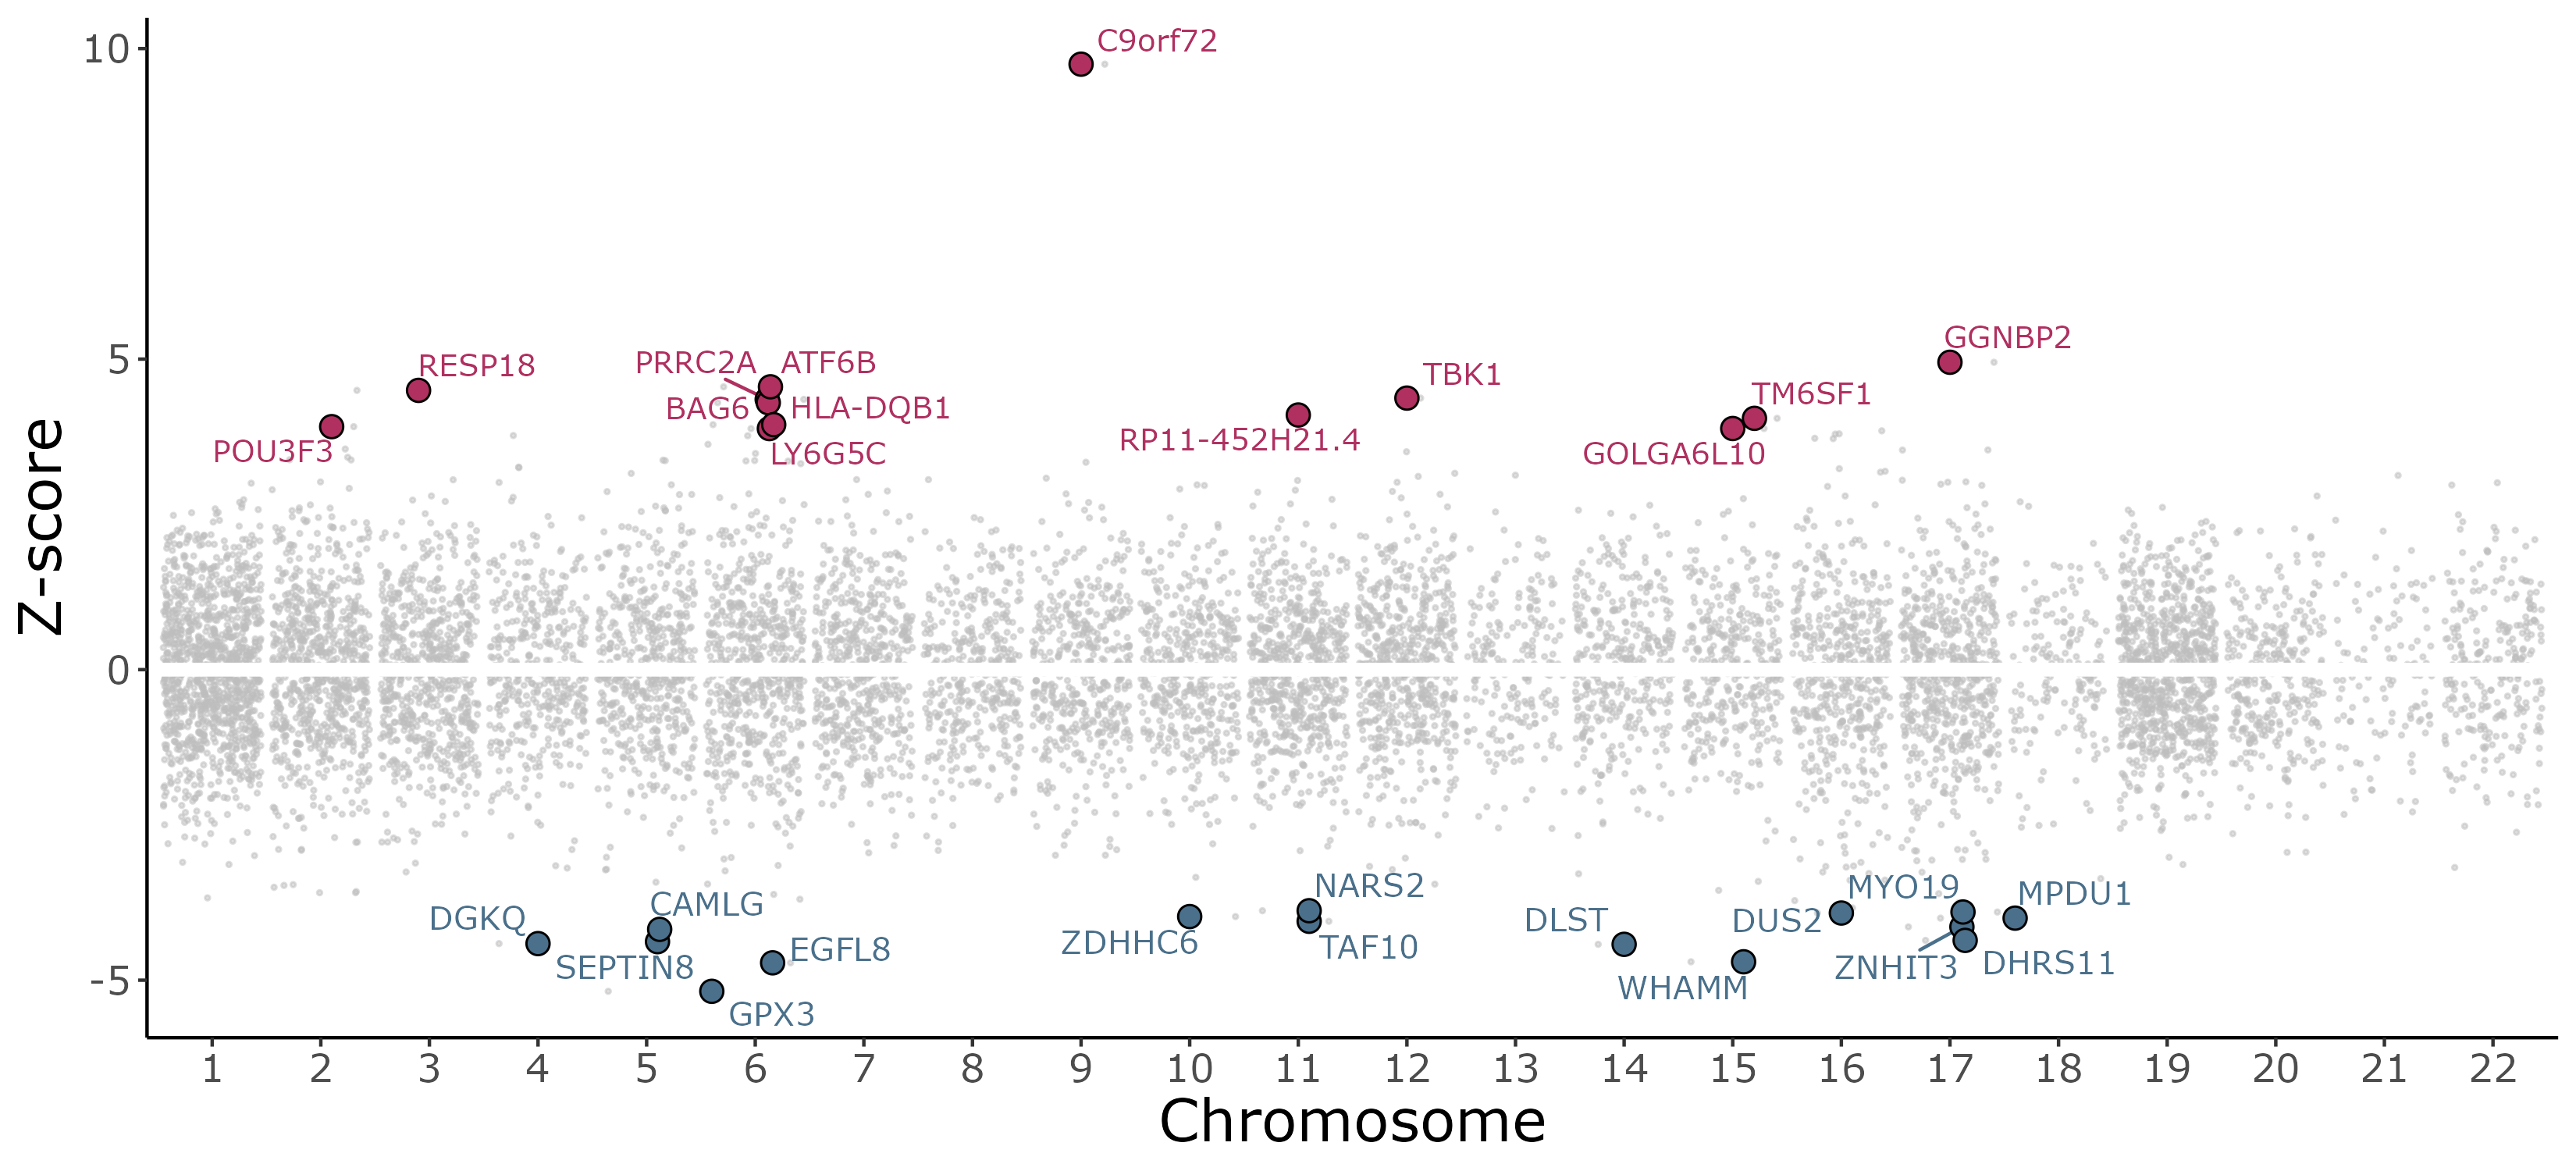

In [108]:
from IPython.display import Image
Image(filename='/data/ALS_50k/SaraSaez_ALS/PROJECT4_DrugRepositioning/2021-06-01.Disease_Signatures/Results/trial.SpinalCord.c1.VR.ALS.onlyFDR.nocolor.png')
